# Project Proposal Group 33



### Predicting a Tennis Player's Best Rank Based on Their Age, Seasons Played, Current Rank, and Prize Money

### Introduction


Tennis is a popular sport with a history of competitive tournaments and rankings. Tennis player rankings are essential to evaluate their performance but predicting a player's best rank can be difficult. This project aims to use K-nearest neighbor regression to predict a player's best rank based on age, seasons played, current rank, and prize money. The dataset will be analyzed using five-fold cross-validation, and visualization techniques such as scatter plots will provide insight into factors that influence ranking.

### Preliminary Data Analysis


In [14]:
library(tidyverse)
library(repr)
library(tidymodels)

In [15]:
url <- "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
tennis_data <- read_csv(url)
head(tennis_data, n=10)

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,Age,Country,Plays,Wikipedia,Current Rank,Best Rank,Name,Backhand,Prize Money,⋯,Facebook,Twitter,Nicknames,Grand Slams,Davis Cups,Web Site,Team Cups,Olympics,Weeks at No. 1,Tour Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,21 (29-05-1998),"Korea, Republic of",Right-handed,Wikipedia,236 (199),130 (10-04-2017),Duck Hee Lee,Two-handed,"$374,093",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,27 (21-10-1992),Australia,Right-handed,Wikipedia,183 (273),17 (11-01-2016),Bernard Tomic,Two-handed,"US$6,091,971",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,22 (11-02-1997),Poland,Right-handed,Wikipedia,31 (1398),31 (20-01-2020),Hubert Hurkacz,Two-handed,"$1,517,157",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,28 (18-11-1991),United States,Right-handed,Wikipedia,307 (131),213 (31-10-2016),Sekou Bangoura,Two-handed,"$278,709",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,21 (12-05-1998),"Taiwan, Province of China",Right-handed,Wikipedia,232 (205),229 (04-11-2019),Tung Lin Wu,Two-handed,"$59,123",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
8,25 (29-07-1994),Uzbekistan,Right-handed,Wikipedia,417 (81),253 (17-07-2017),Sanjar Fayziev,Two-handed,"$122,734",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


For our project we chose the columns Age, Best Rank, Prize Money, Current Rank, and Seasons. These predictors were selected because they contain the most data compared to other columns which mostly contain N/As and all these variables have a direct or indirect impact on a player's performance.

We also isolated our desired variables, deleted empty observations, and removed unnecessary characters. 

In [16]:
colnames(tennis_data) <- make.names(colnames(tennis_data))
tennis_data_separated <- tennis_data |> select(Age, Best.Rank, Prize.Money, Seasons, Current.Rank) |>
                separate(col = Age,
                        into = c("Age", "date"),
                        sep=" ",
                        convert=TRUE) |>
                separate(col = Best.Rank,
                        into = c("best_rank", "date_rank"),
                        sep=" ",
                        convert=TRUE) |>

                separate(col = Current.Rank,
                        into = c("current_rank", "date_cur_rank"),
                        sep=" ",
                        convert=TRUE) |>
    select(Age, best_rank, current_rank, Prize.Money, Seasons)

head(tennis_data_separated, n = 10)

Age,best_rank,current_rank,Prize.Money,Seasons
<int>,<int>,<int>,<chr>,<dbl>
26,363,378,NA,NA
18,316,326,"$59,040",NA
32,44,178,"US$3,261,567",14
21,130,236,"$374,093",2
27,17,183,"US$6,091,971",11
22,31,31,"$1,517,157",5
28,213,307,"$278,709",1
21,229,232,"$59,123",1
25,253,417,"$122,734",5


In [17]:
tennis_data_separated$Prize.Money <- gsub("US", " ", tennis_data_separated$Prize.Money)


tennis_data_separated$Prize.Money <- gsub("US", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- gsub("all-time leader in earnings", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- gsub("11th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- gsub("24th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- gsub("10th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("14th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("27th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("15th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("30th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("All-time leader in earnings", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("4th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("28th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("2nd", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("6th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("33rd", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("26th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("24th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("48th", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("41st", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("\\$","", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub(" ", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("   ", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub("  ", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- sub(" all-time in earnings", "", tennis_data_separated$Prize.Money)
tennis_data_separated$Prize.Money <- gsub(",", "", tennis_data_separated$Prize.Money)

tennis_data_renamed <- tennis_data_separated |>
    rename("Best_Rank" = "best_rank") |>
    rename("Current_Rank" = "current_rank")
head(tennis_data_renamed, n = 10)

Age,Best_Rank,Current_Rank,Prize.Money,Seasons
<int>,<int>,<int>,<chr>,<dbl>
26,363,378,NA,NA
18,316,326,59040,NA
32,44,178,3261567,14
21,130,236,374093,2
27,17,183,6091971,11
22,31,31,1517157,5
28,213,307,278709,1
21,229,232,59123,1
25,253,417,122734,5


We also converted the Prize Money column from character into double.

In [18]:
tennis_data_mutated <- tennis_data_renamed |>
    mutate(Prize_Money = as.numeric(Prize.Money)) |>
    na.omit() |>
    select(Age, Best_Rank, Current_Rank, Prize_Money, Seasons)

head(tennis_data_mutated, n = 10)

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Age,Best_Rank,Current_Rank,Prize_Money,Seasons
<int>,<int>,<int>,<dbl>,<dbl>
32,44,178,3261567,14
21,130,236,374093,2
27,17,183,6091971,11
22,31,31,1517157,5
28,213,307,278709,1
21,229,232,59123,1
25,253,417,122734,5
20,104,104,74927,3
19,17,22,1893476,3


We divided the data into 75% training and 25% testing.

In [20]:
tennis_data_split <- initial_split(tennis_data_mutated, prop = .75, strata = Current_Rank)
tennis_data_train <- training(tennis_data_split)
tennis_data_test <- testing(tennis_data_split)
head(tennis_data_train, n = 10)
head(tennis_data_test, n = 10)

Age,Best_Rank,Current_Rank,Prize_Money,Seasons
<int>,<int>,<int>,<dbl>,<dbl>
22,31,31,1517157,5
19,17,22,1893476,3
23,4,4,10507693,5
20,47,54,1285541,3
22,25,34,2722314,6
32,11,45,11912152,15
32,9,12,13470614,16
29,23,27,4850190,11
29,32,32,2301746,13


Age,Best_Rank,Current_Rank,Prize_Money,Seasons
<int>,<int>,<int>,<dbl>,<dbl>
21,130,236,374093,2
27,17,183,6091971,11
21,229,232,59123,1
28,143,148,303458,8
31,3,121,25889586,14
22,132,133,507297,2
30,75,123,631094,3
20,187,331,127760,2
27,166,384,238848,4


In [21]:
tennis_data_train_mean <- tennis_data_train |> map_df(mean)
tennis_data_train_median <- tennis_data_train |> map_df(median)

print("Training Tennis Data Mean")
tennis_data_train_mean
print("Training Tennis Data Median")
tennis_data_train_median

[1] "Training Tennis Data Mean"


Age,Best_Rank,Current_Rank,Prize_Money,Seasons
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
26.86765,125.011,207.6544,3634158,6.591912


[1] "Training Tennis Data Median"


Age,Best_Rank,Current_Rank,Prize_Money,Seasons
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
27,97.5,194.5,711388.5,5


The tables above show that the data needs to be standardized because they have very different ranges and Prize Money has significant outliers.

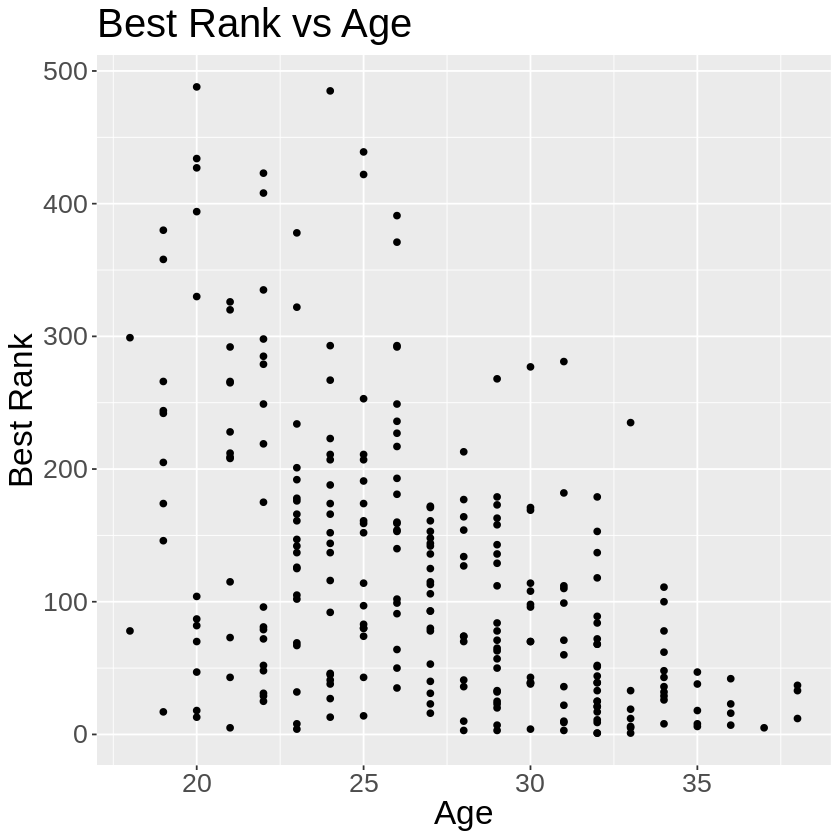

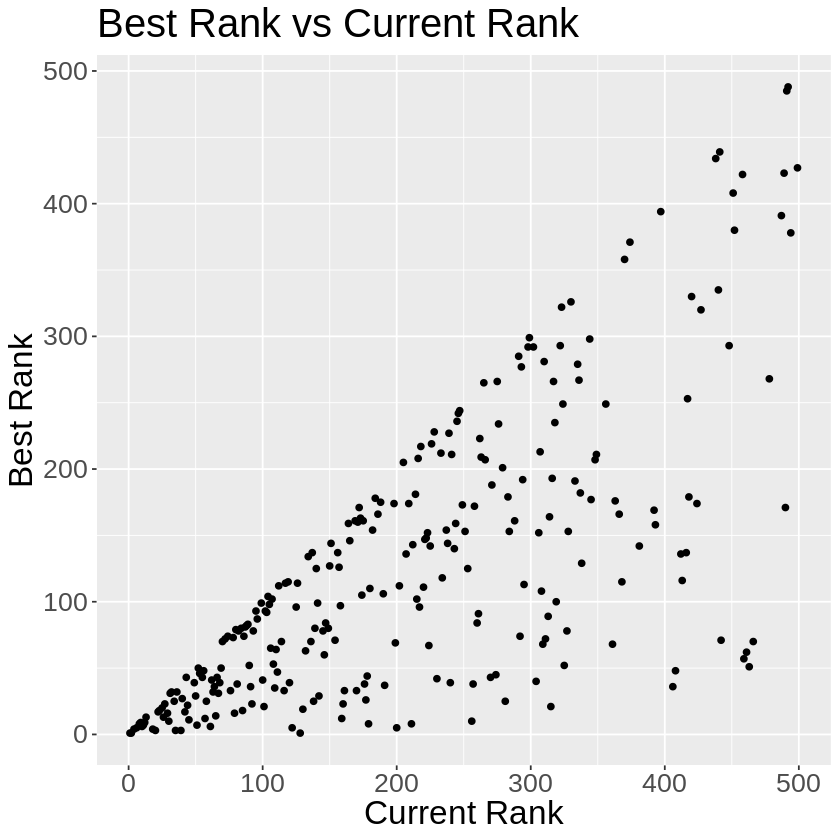

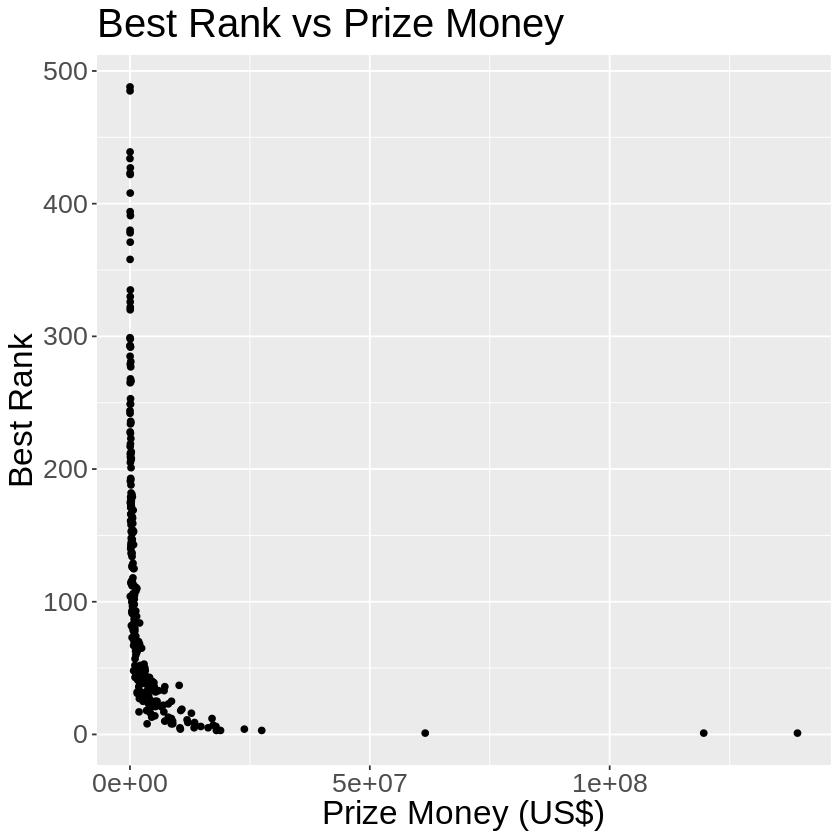

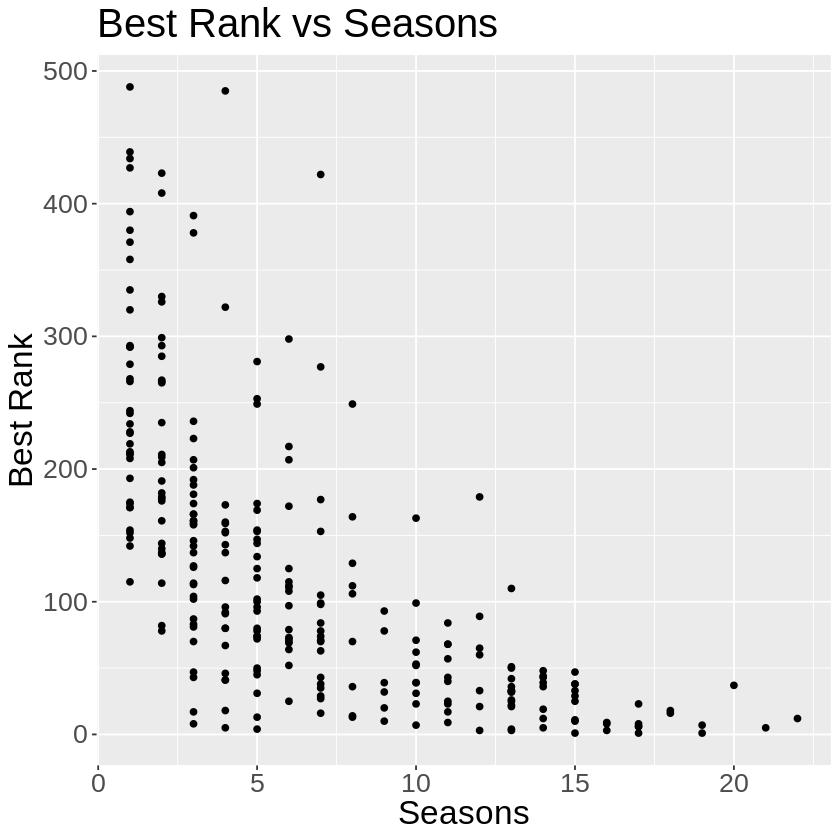

In [22]:
ggplot(tennis_data_train, aes(x = Age, y = Best_Rank)) +
    geom_point() +
    labs(title = "Best Rank vs Age", x = "Age", y = "Best Rank") +
    theme(text = element_text(size = 20))

ggplot(tennis_data_train, aes(x = Current_Rank, y = Best_Rank)) +
    geom_point() +
    labs(title = "Best Rank vs Current Rank", x = "Current Rank", y = "Best Rank") +
    theme(text = element_text(size = 20))

ggplot(tennis_data_train, aes(x = Prize_Money, y = Best_Rank)) +
    geom_point() +
    labs(title = "Best Rank vs Prize Money", x = "Prize Money (US$)", y = "Best Rank") +
    theme(text = element_text(size = 20))

ggplot(tennis_data_train, aes(x = Seasons, y = Best_Rank)) +
    geom_point() +
    labs(title = "Best Rank vs Seasons", x = "Seasons", y = "Best Rank") +
    theme(text = element_text(size = 20))

As seen from the plots above, Age and Best Rank have a weak negative linear relationship which suggests that statistically, age has an impact on a player's best rank, which is why we chose this predictor. Furthermore, Best Rank and Current Rank have a strong positive linear relationship which indicates that a player's Current Rank influences their projected Best Rank. We also noted that Current Rank can never be numerically lower than the Best Rank. Moreover, Best Rank and Prize Money have a negative exponential relationship, meaning that only the highest ranking players are winning extremely large sums; as a player's rank decreases as their winnings increase. There is also a weak exponential decay relationship between Best Rank and Seasons which indicates that the more seasons a player has played, the more likely they are to have a lower rank. All of these variables have a distinct influence on the Best Rank which is why we chose as our predictors in our model.

### Methods

We plan on Using K-nearest neighbor regression since all variables are quantitative. We will standardize the data and determine K depending on the smallest estimated error determined from the five fold cross validation. We will evaluate the optimal parameter value by using the standard testing dataset to calculate the standard error for all variables to ensure we have sufficient amount of predictors.

We will use similar scatter plots as the ones above with our standardized data, the predictors will be on the x-axis of their individual plots and the predicted Best Rank will be on the y-axis. 

### Expected Outcomes

Higher Best rank is expected to be associated with the older players. As they get older, they play more seasons and gain more experience and their rank decreases, meaning that they improved. We expect that players with higher prize money will have lower best ranks since this means they have been winning larger tournaments. Furthermore, players who have a lower current rank will also have a lower best rank because we don't expect there to be so much discrepancy between the two variables. 

Our model will produce doubles instead of integers. We will round them to integers so that our prediction is more intuitive, eaiser to interpret and compare.

This model could help future tennis players to predict the trajectory of their career based on their seasons played, current rank, age, and prize money.

This leads to some questions:
Are there other variables that have a significant impact on a tennis player's best rank?

Is this model applicable to other individual player sports such as golf?


### References

"Player Stats for Top 500 Players" from: 
 https://www.ultimatetennisstatistics.com/
 Accesed through UBC Canvas:
https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS